# Preffered Positions Prediction

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Introduction

In this notebook, I aim to predict the preferred player position of a football player based on their fifa performance ratings on various positions. I compare the prediction accuracy of models trained using a subset of specific player position as variables and a model trained using all available position variables.

# Data cleaning
Removing unused columns

In [ ]:
df = pd.read_csv('PlayerPlayingPositionData.csv', low_memory=False)
df.drop(columns=['Unnamed: 0', 'ID'], inplace=True)
df.head()

,CAM,CB,CDM,CF,CM,LAM,LB,LCB,LCM,LDM,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,89.0,53.0,62.0,91.0,82.0,89.0,61.0,53.0,82.0,62.0,...,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,92.0,45.0,59.0,92.0,84.0,92.0,57.0,45.0,84.0,59.0,...,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
2,88.0,46.0,59.0,88.0,79.0,88.0,59.0,46.0,79.0,59.0,...,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0
3,87.0,58.0,65.0,88.0,80.0,87.0,64.0,58.0,80.0,65.0,...,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Goalkeeper

All values of the goalkeepers are missing. It may be necessary to either impute the missing data using a more suitable method or exclude goalkeepers from the analysis altogether. I choose to exclude goalkeepers for now. If time permits, it could be worthwhile to explore the use of replacing the NaN with zeros as a potential imputation method.

In [ ]:
df = df.dropna()

### Preffered Positions

Extracting the first position value for each player and use it as the dependent variable. This variable will represent the player's preferred position, which the aim is to predict later.

In [ ]:
df['first_position'] = df['Preferred Positions'].str.split().str[0]
df = df.drop("Preferred Positions", axis=1)
df.head()

,CAM,CB,CDM,CF,CM,LAM,LB,LCB,LCM,LDM,...,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST,first_position
0,89.0,53.0,62.0,91.0,82.0,89.0,61.0,53.0,82.0,62.0,...,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0,ST
1,92.0,45.0,59.0,92.0,84.0,92.0,57.0,45.0,84.0,59.0,...,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0,RW
2,88.0,46.0,59.0,88.0,79.0,88.0,59.0,46.0,79.0,59.0,...,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0,LW
3,87.0,58.0,65.0,88.0,80.0,87.0,64.0,58.0,80.0,65.0,...,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0,ST
5,84.0,57.0,62.0,87.0,78.0,84.0,58.0,57.0,78.0,62.0,...,57.0,78.0,62.0,87.0,82.0,88.0,84.0,61.0,88.0,ST


### Dummy Data for labels / target variables
In order to facilitate further analysis and correlation checking, we will create dummy data for the player's preferred position.

In [ ]:
position_labels = pd.get_dummies(df["first_position"], prefix='target')
position_labels.head()

,target_CAM,target_CB,target_CDM,target_CF,target_CM,target_LB,target_LM,target_LW,target_LWB,target_RB,target_RM,target_RW,target_RWB,target_ST
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Subset

Due to the large number of columns in the dataset, it is necessary to reduce the number of features in order to build a more efficient and effective model. I base this on my knowledge of the topic and try to validate it later with some correlations.

![](https://fifauteam.com/images/fifa21/positions/positionsmap.jpg)
(Lopes, 2021)

This are all favorite positions on our dataset:

In [ ]:
df["first_position"].value_counts()

CB     2705
ST     2277
CM     1977
CDM    1396
RM     1350
LM     1326
LB     1309
RB     1195
CAM    1125
RW      429
LW      427
CF      205
LWB     120
RWB     111
Name: first_position, dtype: int64

In [ ]:
df_player_values = df[["CB", "RM", "LM", "CAM", "RW", "LW", "ST"]]

# Exploratory data analysis

To better understand the relationships between preferred player positions and attributes specific to each position, I use some violin graphs and select 3 diverging player positions (center-back (CB), center-midfielder (CM), and striker (ST)).

## Preferred positions & Position attributes

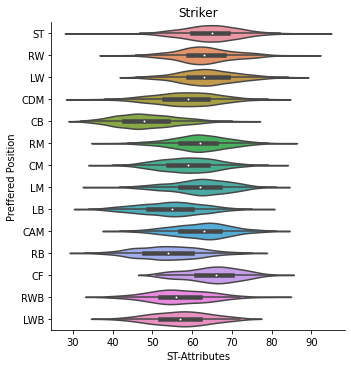

In [ ]:
sns.catplot(x="ST", y="first_position", kind="violin", data=df)
plt.title('Striker')
plt.xlabel("ST-Attributes")
plt.ylabel("Preffered Position")
plt.show()

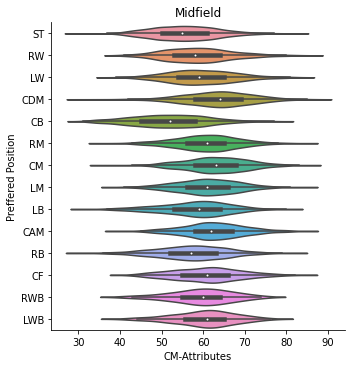

In [ ]:
sns.catplot(x="CM", y="first_position", kind="violin", data=df)
plt.title('Midfield')
plt.xlabel("CM-Attributes")
plt.ylabel("Preffered Position")
plt.show()

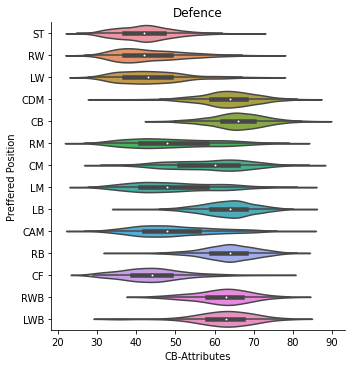

In [ ]:
sns.catplot(x="CB", y="first_position", kind="violin", data=df)
plt.title('Defence')
plt.xlabel("CB-Attributes")
plt.ylabel("Preffered Position")
plt.show()

It looks like there will be a pattern at least in the distinction of the 3 positions. Where ST and CM have a very close pattern, CB is more different. This gives me hope that a rough prediction between offense, midfield and defense is possible.

## Correlation Overview

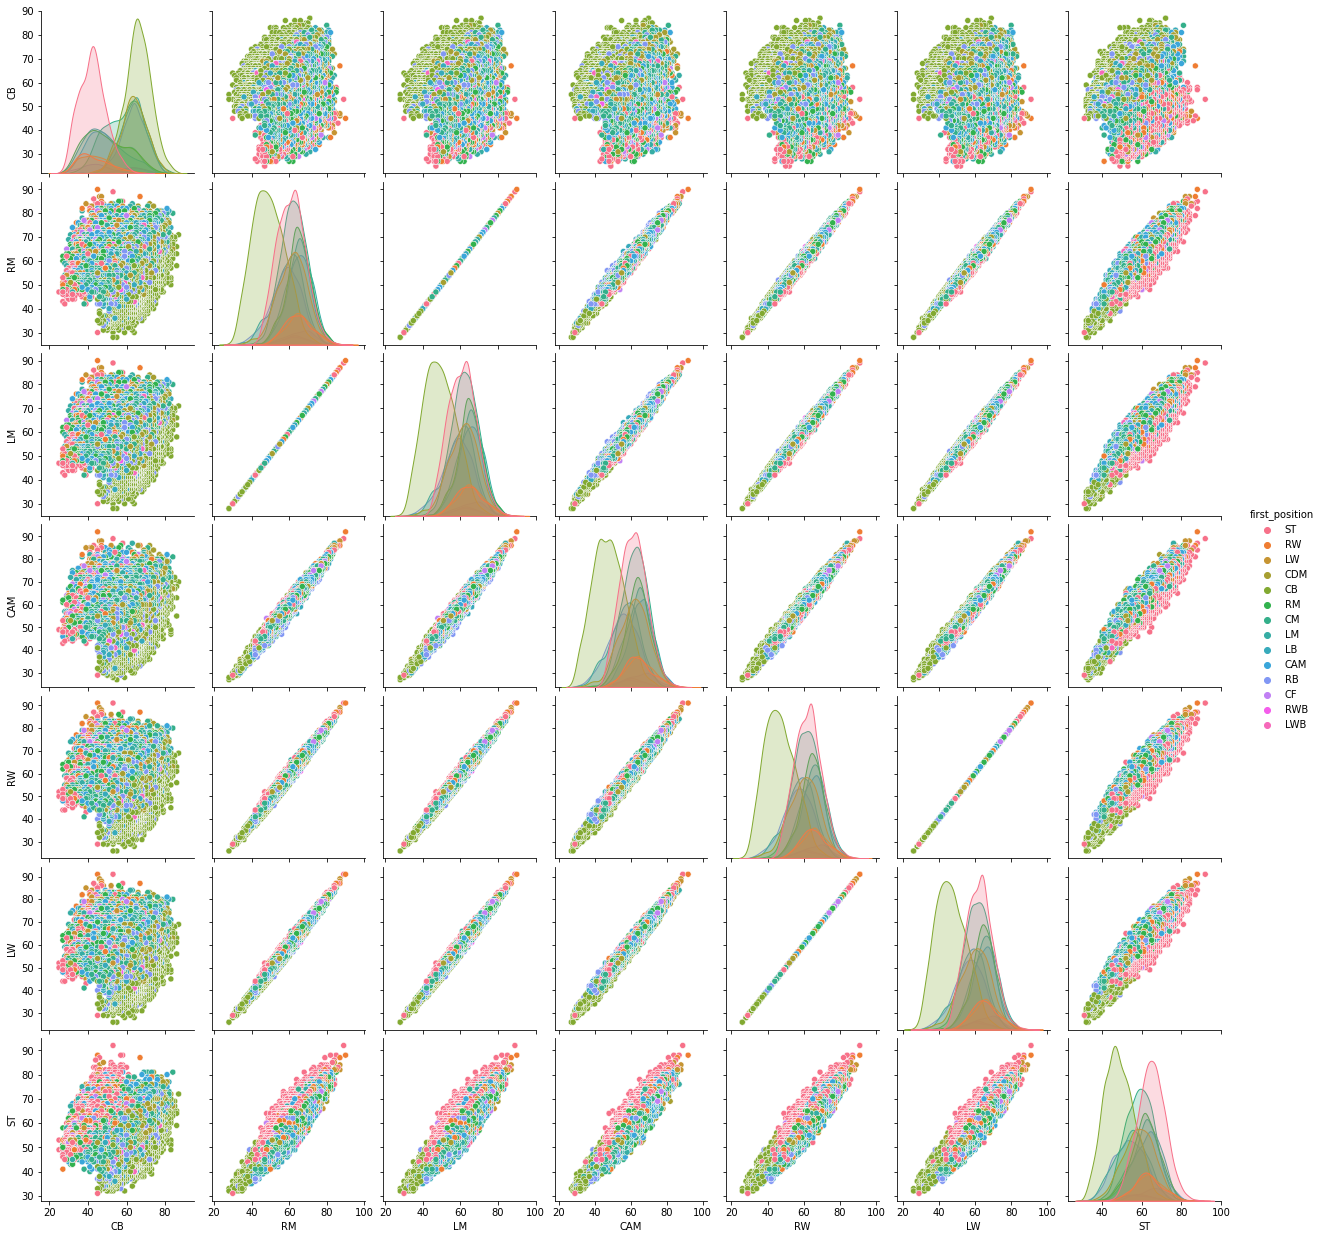

In [141]:
sns.pairplot(df, vars=["CB", "RM", "LM", "CAM", "RW", "LW", "ST"], hue='first_position')
plt.show()

There are large correlations between player position ratings. Unfortunately, there are also very strong correlations between a position's left and right sides. This can and probably will lead to problems later on to predict if a player prefers to play on the right or left side, if his ratings in this respect hardly differ.

In [ ]:
df_comb = pd.concat([df_player_values, position_labels], axis=1)
df_corr = pd.DataFrame(df_comb.corr())
df_corr = df_corr.iloc[:, 7:]
df_corr = df_corr.iloc[:7, :]
df_corr

,target_CAM,target_CB,target_CDM,target_CF,target_CM,target_LB,target_LM,target_LW,target_LWB,target_RB,target_RM,target_RW,target_RWB,target_ST
CB,-0.135883,0.380388,0.200320,-0.106403,0.095883,0.188436,-0.148566,-0.158611,0.049327,0.184049,-0.155252,-0.166137,0.043415,-0.444547
RM,0.147530,-0.534587,0.043979,0.066390,0.089679,-0.029137,0.163839,0.099679,0.021967,-0.051962,0.157802,0.082536,0.015697,0.037907
LM,0.147530,-0.534587,0.043979,0.066390,0.089679,-0.029137,0.163839,0.099679,0.021967,-0.051962,0.157802,0.082536,0.015697,0.037907
CAM,0.167822,-0.530337,0.065981,0.075848,0.118527,-0.086084,0.148891,0.098731,0.004978,-0.105542,0.142757,0.081543,-0.000606,0.088240
RW,0.156557,-0.568611,0.016018,0.078783,0.066921,-0.054054,0.174430,0.117190,0.015116,-0.076356,0.168689,0.100584,0.009381,0.115486
LW,0.156557,-0.568611,0.016018,0.078783,0.066921,-0.054054,0.174430,0.117190,0.015116,-0.076356,0.168689,0.100584,0.009381,0.115486
ST,0.120394,-0.472753,0.005271,0.084942,0.026370,-0.122329,0.120755,0.099704,-0.009600,-0.131471,0.116098,0.089119,-0.011964,0.287817


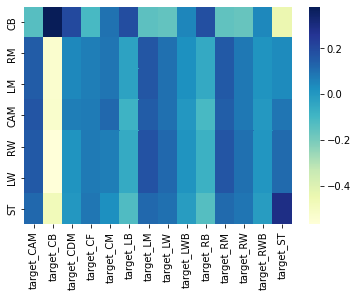

In [ ]:
sns.heatmap(df_corr, cmap="YlGnBu", annot=False)
plt.show()

The correlation heatmap again shows us the correlation/pattern of preferred positions & position attributes mentioned above. Also, you can see that there can be difficulties in distinguishing between the left and right positions.

# Predictive model & Evaluation

In the following we prepare the data once with a subset of the position attributes and once all position attributes as variables to fit a random forest classifier.

In [ ]:
# Selected Variables
X = df_comb.loc[:, "CB":"ST"]
X = normalize(X)

# All Variables
X_full = df.loc[:, "CAM":"ST"]
X_full = normalize(X_full)

y = df['first_position']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(X_full, y, test_size=0.3, random_state=1)

## Random Forest on selected Variables

In [ ]:
rf = RandomForestClassifier(n_estimators=1000, random_state=1)
model = rf.fit(X_train, y_train)
rf_y_pred = model.predict(X_test)
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

         CAM       0.25      0.24      0.25       346
          CB       0.70      0.83      0.76       814
         CDM       0.31      0.26      0.28       418
          CF       0.23      0.14      0.18        49
          CM       0.37      0.45      0.41       561
          LB       0.36      0.36      0.36       419
          LM       0.16      0.14      0.15       399
          LW       0.05      0.02      0.03       127
         LWB       0.18      0.06      0.09        34
          RB       0.30      0.25      0.27       378
          RM       0.24      0.25      0.24       395
          RW       0.06      0.02      0.03       131
         RWB       0.15      0.06      0.08        36
          ST       0.67      0.80      0.73       679

    accuracy                           0.43      4786
   macro avg       0.29      0.28      0.28      4786
weighted avg       0.40      0.43      0.41      4786



This model is correct in its predictions about 43% of the time. The recall macro average of 0.28 indicates that the model correctly identifies 28% of all actual positive instances across all classes, which is not much. The precision macro average of 0.29 means that the model makes correct predictions about 29% of the time.

However, we can see that clear positions (without right/left position) like ST and CB perform much better than the other positions. This confirms our observation on the graphs, where these two positions had very different patterns compared to the other positions.

## Random Forest on all Variables

In [ ]:
rf = RandomForestClassifier(n_estimators=1000, random_state=1)
model = rf.fit(X_full_train, y_full_train)
rf_y_full_pred = model.predict(X_full_test)
print(classification_report(y_full_test, rf_y_full_pred))

              precision    recall  f1-score   support

         CAM       0.31      0.26      0.28       346
          CB       0.71      0.85      0.77       814
         CDM       0.35      0.28      0.31       418
          CF       0.54      0.14      0.23        49
          CM       0.36      0.50      0.42       561
          LB       0.40      0.47      0.43       419
          LM       0.26      0.19      0.22       399
          LW       0.21      0.06      0.09       127
         LWB       0.50      0.03      0.06        34
          RB       0.36      0.27      0.31       378
          RM       0.27      0.28      0.27       395
          RW       0.17      0.04      0.06       131
         RWB       0.50      0.03      0.05        36
          ST       0.68      0.85      0.75       679

    accuracy                           0.47      4786
   macro avg       0.40      0.30      0.30      4786
weighted avg       0.44      0.47      0.45      4786



This model is correct in its predictions about 47% of the time. The recall macro average of 0.30 indicates that the model correctly identifies 40% of all actual positive instances across all classes, which is just slightly better than our subset trained model. The precision macro average of 0.40 means that the model makes correct predictions about 40% of the time, thats way better than our subset trained model.

However, here we can again see that clear positions (without right/left position) like ST and CB perform much better than the other positions. 

This would have to be a main focus in a further iteration.

# Conclusion

Both  results suggest that both models are performing relatively poorly, with relatively low accuracy, recall, and precision. As it looks, it is hard to predict the preferred position from the position attributes alone. In the next step, I would have to find better or more variables to distinguish the nuanced differences between the placements (left, right, center).

# Literature

Lopes, R. (2021, Januar 12). FIFA 21 Positions Guide for Ultimate Team. | FIFA Ultimate Team. https://fifauteam.com/fifa-21-positions/
